#PROJECT : Analysis of Users Preferences between Android and iOS 
Here we'll implement a sentiment analysis analysisng preferences of users between Android and iOS.


In [114]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import json, time, sys, io, pickle
import re
import tweepy
import nltk
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import hashlib
import glob
import math
from decimal import *
from __future__ import division
from matplotlib import pyplot as plt
# %matplotlib inline

In [2]:
access_token = "97387398-09aWi5l77s95Vy7Jag58WvQ1soy9TzoGCA0vruWH5"
access_token_secret = "ZzBHbF3LjXg7Wl40VIa6nJomv1TdwQW9Am1oQRzIW0RLN"
consumer_key = "Ii9orQvVcYDTzbk5feDFIuz1n"
consumer_secret = "MXTqped02xYhyuer6IpO2Rt2377MRGsTHhJQnMZ9aOagGrTLnD"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


In [3]:
class TweetsListener(tweepy.StreamListener):

    def __init__(self, filename=None, api=None):
        super(TweetsListener, self).__init__()
        self.num_tweets = 0
        self.filename = filename
        self.stopHashTagList = ["#androidgames","#gamesinsight"]
        
    def on_status(self, status): 
        text = status.text.encode('utf-8').strip().lower()
        if not any(x in text for x in self.stopHashTagList) and not text.startswith('rt') and not text.startswith('RT'):
            record = {'Text': text, 'Created At': str(status.created_at)}
            if self.num_tweets < 1000:
                try:
                    with open(self.filename, 'a') as f:
                        print text
                        pickle.dump(record,f)
                        self.num_tweets += 1
                    return True
                except BaseException as e:
                    print("Error on_status: %s" % str(e))
            else:
                return False
        
    def on_error(self, status):
        print 'Error on status', status

    def on_limit(self, status):
        print 'Limit threshold exceeded', status

    def on_timeout(self, status):
        print 'Stream disconnected; continuing...'

In [4]:
# stream = Stream(auth, TweetsListener(filename = 'data_android.json'))
# stream.filter(track=['android','androidvsios','iosvsandroid'],languages=['en'])


In [5]:
# stream = Stream(auth, TweetsListener(filename = 'data_both.json'))
# stream.filter(track=['AndroidVSiOS','googlevsios','iosvsgoogle','applevsandroid','iphoneisbetter','androidisbetter'],languages=['en'])

In [6]:
# stream = Stream(auth, TweetsListener(filename = 'data_ios.json'))
# stream.filter(track=['iphone','ios','androidvsios','iosvsandroid'],languages=['en'])

In [7]:
def readTweets(filename):
    list = []
    with open(filename, 'r') as f:
        for x in range(0,1000):
            list.append(pickle.load(f)['Text'])
    return list


In [8]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    text = re.sub(r'[\x85]',"",text)
    tokens = tokenize_with_punct(text)
    i=0
    while i< len(tokens):
        if tokens[i] == "not":
            if(i+1 < len(tokens)):
                tokens[i+1] = 'not_' + tokens[i+1]
            if(i+2 < len(tokens)):
                tokens[i+2] = 'not_' + tokens[i+2]
            i = i+3
        else:
            i = i+1
    return tokens

In [9]:
def writeListToTextFile(list,filename):
    f = open(filename, "w")
    for item in list:
      print>>f, item

In [10]:
# list_android = readTweets('data_android.json')
# writeListToTextFile(list_android,'data_android.txt')
# list_ios = readTweets('data_ios.json')
# writeListToTextFile(list_ios,'data_ios.txt')

In [11]:
def processTweet(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet
#end

#Read the tweets one by one and process it


In [12]:
def preProcessTweets(filename):
    fp = open(filename, 'r')
    fpn = open('process'+filename,'w')
    line = fp.readline()
    while line:
        processedTweet = processTweet(line)
        print>>fpn, processedTweet
        line = fp.readline()
    #end loop
    fp.close()

In [13]:
# preProcessTweets('data_android.txt')
# preProcessTweets('data_ios.txt')

In [14]:
def replaceTwoOrMore(s):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

In [15]:
def getStopWordList(stopWordListFileName):
    stopWords = []
    stopWords.append('AT_USER')
    stopWords.append('URL')

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    #print line
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

In [16]:
def getFeatureVector(tweet,stopWords):
    featureVector = []
    words = tweet.split()
    for w in words:
        w = replaceTwoOrMore(w)
        w = w.strip('\'"?,.')
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
        if(w in stopWords or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return featureVector

In [17]:
stopWords = getStopWordList('stopwords.txt')
featureList = []
def featureExtraction(filename):
    tweets = []
    fp = open(filename,'r')
    line = fp.readline()
    while line:
        linearray = line.split('-',1)
        sentiment = linearray[0]
        tweet = linearray[1]
        processedTweet = processTweet(tweet)
        featureVector = getFeatureVector(processedTweet,stopWords)
        featureList.extend(featureVector)
        tweets.append((featureVector,sentiment))
        line = fp.readline()  
    return(tweets,featureList)

In [18]:
def getStatisticsAboutTweets(filename):
    fp = open(filename,'r')
    tweets = []
    line = fp.readline()
    while line:
        tweets.append(line)
        line = fp.readline()
    return tweets

In [19]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in featureList:
        features['contains(%s)' % word] = (word in tweet_words)
    return features

In [112]:
def plotBarGraph(classification1, classification2, dataRange, N=3):
    index = np.arange(N)    # the x locations for the groups
    bar_width = 0.35       # the width of the bars: can also be len(x) sequence
#     plt.figure()
#     p1 = plt.bar(ind, classification, width, color='r')
#     plt.ylabel('Number of Tweets')
#     plt.title('Classification')
#     plt.xticks(ind + width/2., ('Postive', 'Neutral', 'Negative'))
#     plt.yticks(dataRange)
#     plt.show()
#     n_groups = 3

#     means_men = (20, 35, 30, 35, 27)
#     std_men = (2, 3, 4, 1, 2)

#     means_women = (25, 32, 34, 20, 25)
#     std_women = (3, 5, 2, 3, 3)

    fig, ax = plt.subplots()


    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, classification1, bar_width,
                     alpha=opacity,
                     color='b',
                     error_kw=error_config,
                     label='iOS')

    rects2 = plt.bar(index + bar_width, classification2, bar_width,
                     alpha=opacity,
                     color='r',
                     error_kw=error_config,
                     label='Android')

    plt.xlabel('Sentiment Classification')
    plt.ylabel('Number of tweets')
    plt.title('Sentiment Classification of Tweets')
    plt.xticks(index + bar_width, ('Positve', 'Neutral', 'Negative'))
    plt.yticks(dataRange)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [107]:
def predictUserPreferences(trainFileName, testFileName):
    featureList = []
    tweets,featureList = featureExtraction(trainFileName)
    featureList = list(set(featureList))
    training_set =  nltk.classify.util.apply_features(extract_features, tweets)
    NBClassifier = nltk.NaiveBayesClassifier.train(training_set)
    analyzedTweets = getStatisticsAboutTweets(testFileName)
    print "Total tweets analyzed : " + str(len(analyzedTweets))
    predictedNegativeTweetsLabel = []
    predictedPositiveTweetsLabel = []
    predictedNeutralTweetsLabel = []
    for tweet in analyzedTweets:
        processedTestTweet = processTweet(tweet)
        label = NBClassifier.classify(extract_features(getFeatureVector(processedTestTweet,stopWords)))
        if label == 'n':
            predictedNegativeTweetsLabel.append((tweet,label))
        elif label == 'p':
            predictedPositiveTweetsLabel.append((tweet,label))
        elif label == 'ne':
            predictedNeutralTweetsLabel.append((tweet,label))
            
    percentPositive = (len(predictedPositiveTweetsLabel)/len(analyzedTweets)) * 100
    percentNegative = (len(predictedNegativeTweetsLabel)/len(analyzedTweets)) * 100
    percentNeutral = (len(predictedNeutralTweetsLabel)/len(analyzedTweets)) * 100
    print "Positive Percentage " + str(percentPositive)
    print "Negative Percentage " + str(percentNegative)
    print "Neutral Percentage " + str(percentNeutral)
    
    if(percentPositive > percentNegative):
        print "Users prefer iOS more!!"
    elif(percentPositive < percentNegative):
        print "Users dont prefer iOS!!"
    elif(percentPositive == percentNegative):
        print "User preferences are neutral"

    #plot graph
    classification = [len(predictedPositiveTweetsLabel),len(predictedNeutralTweetsLabel),len(predictedNegativeTweetsLabel)]
    
    return classification
#     plotBarGraph(classification,dataRange)
    

Total tweets analyzed : 1332
Positive Percentage 6.90690690691
Negative Percentage 1.35135135135
Neutral Percentage 91.7417417417
Users prefer iOS more!!
Total tweets analyzed : 1306
Positive Percentage 3.29249617152
Negative Percentage 0.918836140888
Neutral Percentage 95.7886676876
Users prefer iOS more!!


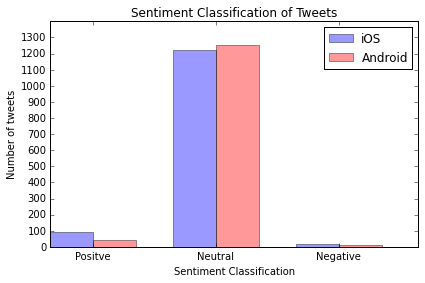

In [116]:
classification1 = predictUserPreferences('data/newdata_ios.txt','data_ios.txt')
classification2 = predictUserPreferences('data/newdata_android.txt','data_android.txt')
dataRange = np.arange(0,1400,100)
plotBarGraph(classification1,classification2,dataRange)

In [117]:
def calculateWeightedAverage():
    

# Verifying Accuracy with Cross Validation

In [85]:
testfilename = 'data/newdata_ios.txt'

In [86]:
def get_true_labels(file_name):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_name....file containing labelled tweets
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    array = []
    fp = open(file_name,'r')
    line = fp.readline()
    while line:
        linearray = line.split('-')
        if linearray[0] == 'p':
            array.append(1)
        elif linearray[0] == 'n':
            array.append(0)
        elif linearray[0] == 'ne':
            array.append(-1)
        line = fp.readline()
    values = np.array(array)
    return values
    ###

labels = get_true_labels(testfilename)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [-1 -1 -1  1  0  1]


In [87]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    UPDATE: To be more specific, a token is a sequence of 
    alphanumeric characters, i.e., [A-Za-z0-9_]. Non-ascii characters
    are not considered to be part of tokens.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
#     text = re.sub(r'[\x85]',"",text)
    return re.sub('\W+', ' ', text.lower()).split()
    ###

tokenize("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 'how',
 's',
 'it',
 'going',
 'an_underscore',
 'is',
 'not',
 'really',
 'punctuation']

In [88]:
def do_vectorize(filename, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    fp = open(filename,'r')
    contentList = []
    line = fp.readline()
    while line:
        contentList.append(line)
        line = fp.readline()
    vectorizer = CountVectorizer(input = 'content', tokenizer = tokenizer_fn, max_df = max_df, min_df = min_df, binary = binary, dtype = int)
    X = vectorizer.fit_transform(contentList)
    return (X,vectorizer)
    ###
    
matrix, vec = do_vectorize(testfilename)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 522 documents with 1810 features
first doc has terms:
[90, 127, 133, 143, 145, 389, 403, 405, 438, 452, 649, 760, 815, 827, 863, 1110, 1192, 1407, 1440, 1448, 1504, 1668, 1685, 1691]


In [68]:
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

trainTweets = []
trainiOSFiles = open(testfilename,'r')
trainiOSTweet = trainiOSFiles.readline()
while trainiOSTweet:
    trainTweets.append(trainiOSTweet)
    trainiOSTweet = trainiOSFiles.readline()

    
X, y, filenames = repeatable_shuffle(matrix, labels, trainTweets)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document n-Hmm, my iPhone isn't doing stuff as "smooth" as before
 has label 0 and terms: [284, 323, 539, 795, 863, 877, 1098, 1101, 1447, 1492, 1504]


In [89]:
def get_clf():
    return LogisticRegression(random_state=42)

In [90]:
def do_cross_validation(X, y, n_folds=3, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    cv = KFold(len(y), n_folds)
    i = 0
    accuracies = []
    for train_idx, test_idx in cv:
        clf = get_clf()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        if verbose :
            print("Fold {} accuracy = {}".format(i,acc))
        i = i + 1
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg
    ###
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

Fold 0 accuracy = 1.0
Fold 1 accuracy = 1.0
Fold 2 accuracy = 1.0
average cross validation accuracy=1.0000


In [91]:
def do_cross_validation_naive(n_folds=5, verbose=False):
    tweets,featureList = featureExtraction(testfilename)
    training_set = nltk.classify.util.apply_features(extract_features, tweets)
    cv = KFold(len(training_set), n_folds, shuffle=True, random_state=None)
    
    for traincv, testcv in cv:
        classifier = nltk.NaiveBayesClassifier.train(training_set[traincv[0]:traincv[len(traincv)-1]])
        accuracy = nltk.classify.util.accuracy(classifier, training_set[testcv[0]:testcv[len(testcv)-1]])
        print accuracy
    
    return accuracy

print('average cross validation accuracy=%.4f' %
      do_cross_validation_naive(n_folds=10, verbose=True))

0.882703777336
0.883196721311
0.879611650485
0.88622754491
0.882936507937
0.882692307692
0.886414253898
0.88
0.885214007782
0.881873727088
average cross validation accuracy=0.8819


In [92]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    ###TODO
    matrix,vec=do_vectorize(filenames,tokenizer_fn, min_df, max_df, binary, ngram_range)
    accuracy=do_cross_validation(matrix, y, n_folds, verbose=False)
    return accuracy

In [93]:
print('accuracy using default settings: %.4g' % do_expt(testfilename, y))

accuracy using default settings: 0.7739


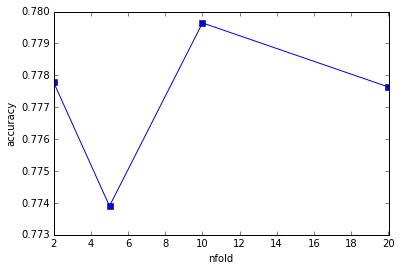

[0.77777777777777779,
 0.77390109890109893,
 0.77964441219158198,
 0.77763532763532761]

In [106]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    ###TODO
    arr_nfolds = [2,5,10,20]
    accuracyList = []
    for nfold in arr_nfolds:
        accuracy = do_expt(filenames, y, n_folds = nfold)
        accuracyList.append(accuracy)
    plt.figure()
    plt.plot(arr_nfolds,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('nfold')
    plt.show()
    return accuracyList
    ###
    
compare_n_folds(testfilename, y)

In [94]:
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    text = re.sub(r'[\x85]',"",text)
    tokens = re.findall(r"[\w]+|[^\s\w]", text.lower())
    return tokens

In [95]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    text = re.sub(r'[\x85]',"",text)
    tokens = tokenize_with_punct(text)
    i=0
    while i< len(tokens):
        if tokens[i] == "not":
            if(i+1 < len(tokens)):
                tokens[i+1] = 'not_' + tokens[i+1]
            if(i+2 < len(tokens)):
                tokens[i+2] = 'not_' + tokens[i+2]
            i = i+3
        else:
            i = i+1
    return tokens
    ###



In [96]:
def tokenizer_expt(y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    ###TODO
    accuracyList = []
    accuracyList.append(do_expt(testfilename,y,tokenizer_fn = tokenize))
    accuracyList.append(do_expt(testfilename,y,tokenizer_fn = tokenize_with_punct))
    accuracyList.append(do_expt(testfilename,y,tokenizer_fn = tokenize_with_not))
    return accuracyList

In [98]:
tokenizer_expt(y)

[0.77390109890109893, 0.77390109890109893, 0.77582417582417584]

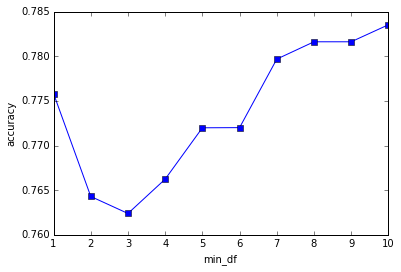

[0.77582417582417584,
 0.7643040293040293,
 0.76239926739926733,
 0.76624542124542117,
 0.77199633699633696,
 0.77201465201465203,
 0.77968864468864463,
 0.78163003663003661,
 0.78163003663003661,
 0.78353479853479846]

In [101]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    ###TODO
    min_dfList = [1,2,3,4,5,6,7,8,9,10]
    accuracyList= []
    for min_df in min_dfList:
        accuracyList.append(do_expt(filenames,y,min_df=min_df,tokenizer_fn=tokenize_with_not))
    plt.figure()
    plt.plot(min_dfList,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('min_df')
    plt.show()
    return accuracyList

min_df_expt(testfilename,y)

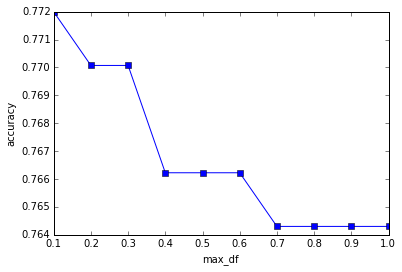

[0.77199633699633696,
 0.77007326007326005,
 0.77007326007326005,
 0.76622710622710621,
 0.76622710622710621,
 0.76622710622710621,
 0.7643040293040293,
 0.7643040293040293,
 0.7643040293040293,
 0.7643040293040293]

In [105]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    ###TODO
    max_dfList = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    accuracyList= []
    for max_df in max_dfList:
        accuracyList.append(do_expt(filenames,y,max_df=max_df, min_df = 2, tokenizer_fn=tokenize_with_not))
    plt.figure()
    plt.plot(max_dfList,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('max_df')
    plt.show()
    return accuracyList
    ###
max_df_expt(testfilename,y)